# Import Dependencies
We begin by importing the necessary libraries. 

In [1]:
# Data analysis
import pandas as pd
import geopandas as gpd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
sns.set()
sns.set_style('white')

# Data Cleaning

Read in the relevant data, starting with the countries shapefile (source: [https://geodata.lib.utexas.edu/catalog/stanford-yf665vp7551](https://geodata.lib.utexas.edu/catalog/stanford-yf665vp7551)). 

In [2]:
# Read data
countries = gpd.read_file('../data/Europe_SWAsia/Europe_SWAsia.shp')
# Drop irrelevant columns
countries = countries[['NAME', 'geometry']]
# Rename Gaza Strip & West Bank to Palestine
countries.loc[countries[countries['NAME'].isin(['Gaza Strip', 'WEST BANK'])].index, 'NAME'] = 'PALESTINE'
# Display results
countries.head()

,NAME,geometry
0,ICELAND,"POLYGON ((-20.58917 63.30328, -20.60169 63.296..."
1,ICELAND,"POLYGON ((-20.49417 63.31753, -20.49672 63.316..."
2,ICELAND,"POLYGON ((-20.39083 63.33081, -20.39506 63.328..."
3,ICELAND,"POLYGON ((-20.39589 63.33747, -20.39672 63.334..."
4,ICELAND,"POLYGON ((-20.36089 63.35994, -20.36339 63.357..."


Once the data are in good shape, filter for countries in the Middle East. Note, our data does not include Egypt, nor will it include contested territories (e.g. "No Man's Land" - claimed by both Israel and Palestine).

Moreover, add a column mapping each Middle Eastern country to their national religion(s).

In [3]:
# Filter for Middle Eastern countries
middle_east_countries = ['bahrain', 'cyprus', 'iran', 'iraq', 
                         'israel', 'jordan', 'kuwait', 'lebanon', 
                         'oman', 'palestine', 'qatar', 'saudi arabia', 
                         'syria', 'turkey', 'united arab emirates', 'yemen']
countries = countries[countries['NAME'].apply(lambda x: x.lower()).isin(middle_east_countries)].reset_index(drop=True)

# Map country to religion(s)
religion = {
    'BAHRAIN': 'Islam',
    'CYPRUS': 'Christianity',
    'IRAN': 'Islam',
    'IRAQ': 'Islam',
    'ISRAEL': 'Judaism',
    'JORDAN': 'Islam',
    'KUWAIT': 'Islam',
    'LEBANON': 'Islam/Christianity',
    'OMAN': 'Islam',
    'PALESTINE': 'Islam',
    'QATAR': 'Islam',
    'SAUDI ARABIA': 'Islam',
    'SYRIA': 'Islam',
    'TURKEY': 'Islam',
    'UNITED ARAB EMIRATES': 'Islam',
    'YEMEN': 'Islam',
}
countries['religion'] = countries['NAME'].apply(lambda x: religion[x])

# Count number of countries in each religion
countries.groupby('religion')['NAME'].nunique().sort_values(ascending=False)

religion
Islam                 13
Christianity           1
Islam/Christianity     1
Judaism                1
Name: NAME, dtype: int64

Next, read in the shapefiles containing important bodies of water (source: [https://www.marineregions.org/gazetteer.php?p=details&id=4266](https://www.marineregions.org/gazetteer.php?p=details&id=4266)). Note, our data source does not include the Caspian Sea, meaning we'll have to pull from a different source ([https://maps.princeton.edu/catalog/stanford-zb452vm0926](https://maps.princeton.edu/catalog/stanford-zb452vm0926)) and concatenate the two together. 

In [4]:
# Read data
caspian_sea = gpd.read_file('../data/Caspian_Sea/XCA_adm0.shp')
world_seas = gpd.read_file('../data/World_Seas_IHO_v3/World_Seas_IHO_v3.shp')
# Drop irrelevant columns
world_seas = world_seas[['NAME', 'geometry']]
caspian_sea = caspian_sea[['NAME_ENGLI', 'geometry']]
# Rename columns
caspian_sea = caspian_sea.rename(columns={'NAME_ENGLI': 'NAME'})
# Merge dataframes
seas = pd.concat([world_seas, caspian_sea])
# Display results
seas.head()

,NAME,geometry
0,Rio de La Plata,"POLYGON ((-54.94302 -34.94791, -54.97875 -34.9..."
1,Bass Strait,"POLYGON ((149.90464 -37.54325, 149.90500 -37.5..."
2,Great Australian Bight,"POLYGON ((143.53251 -38.85535, 143.54856 -38.8..."
3,Tasman Sea,"POLYGON ((159.03333 -30.00000, 159.03983 -30.0..."
4,Mozambique Channel,"POLYGON ((43.38218 -11.37021, 43.42691 -11.374..."


Once again, filter for bodies of water within the vicinity of the Middle East.

In [5]:
# Filter for middle eastern bodies of water
middle_east_water = ['Persian Gulf', 'Gulf of Suez', 'Gulf of Aden', 'Caspian Sea', 'Red Sea', 
                     'Arabian Sea', 'Black Sea', 'Mediterranean Sea - Eastern Basin']
seas = seas[seas['NAME'].isin(middle_east_water)].reset_index(drop=True)
# Display results
seas

,NAME,geometry
0,Gulf of Aden,"POLYGON ((51.28666 11.83501, 51.27958 11.84083..."
1,Red Sea,"POLYGON ((34.71160 28.13827, 34.71577 28.12500..."
2,Persian Gulf,"POLYGON ((56.08700 27.10831, 56.08874 27.11032..."
3,Gulf of Suez,"POLYGON ((32.57319 30.06809, 32.57415 30.05859..."
4,Mediterranean Sea - Eastern Basin,"POLYGON ((12.43104 37.79330, 12.43105 37.79297..."
5,Arabian Sea,"POLYGON ((66.35199 25.59504, 66.35434 25.59310..."
6,Black Sea,"POLYGON ((31.93913 46.93875, 31.94260 46.94105..."
7,Caspian Sea,"POLYGON ((52.86971 40.78276, 52.86163 40.76627..."


# Data Visualization

It remains to create the Middle Eastern map of religions. 

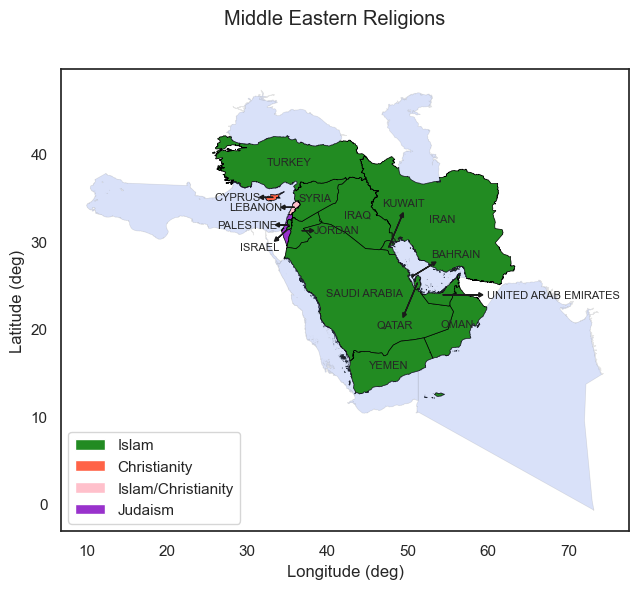

In [6]:
# Dissolve countries by NAME to combine polygons for each country
dissolved = countries.dissolve(by='NAME')

# Create custom color map by religion
religion_colors = {'Islam': 'forestgreen', 
                   'Christianity': 'tomato', 
                   'Islam/Christianity': 'pink',
                   'Judaism': 'darkorchid'}
cmap = ListedColormap([religion_colors[x] for x in dissolved['religion']])

# Plot the map
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle('Middle Eastern Religions')
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')

dissolved.plot(ax=ax, cmap=cmap, legend=True, edgecolor='black', linewidth=0.5)
seas.plot(ax=ax, alpha=0.2, color='royalblue', edgecolor='grey', linewidth=0.5)

# Add legend
legend_labels = {'Islam': 'Islam', 
                 'Christianity': 'Christianity', 
                 'Islam/Christianity': 'Islam/Christianity',
                 'Judaism': 'Judaism'}
legend_handles = [Patch(facecolor=religion_colors[x], label=legend_labels[x]) for x in legend_labels.keys()]
ax.legend(handles=legend_handles, loc='lower left')

# Annotate country names
for idx, row in dissolved.iterrows():
    name = row.name
    centroid = row['geometry'].centroid

    # Annotate small countries to the side with an arrow
    if row['geometry'].area < 10:
        # Custom cases
        if name == 'ISRAEL':
            ax.annotate(text=name, xy=(centroid.x-1, centroid.y-2), fontsize=8, ha='right', va='center')
            ax.arrow(centroid.x, centroid.y, -1.2, -1, head_width=0.5, head_length=0.5, fc='k', ec='k')
        elif name == 'JORDAN':
            ax.annotate(text=name, xy=(centroid.x+1.5, centroid.y), fontsize=8, ha='left', va='center')
            ax.arrow(centroid.x, centroid.y, 1.0, 0.0, head_width=0.5, head_length=0.5, fc='k', ec='k')
        elif name == 'BAHRAIN':
            ax.annotate(text=name, xy=(centroid.x+2.3, centroid.y+2.5), fontsize=8, ha='left', va='center')
            ax.arrow(centroid.x, centroid.y, 2.5, 1.4, head_width=0.5, head_length=0.5, fc='k', ec='k')
        elif name == 'QATAR':
            ax.annotate(text=name, xy=(centroid.x-0.6, centroid.y-4.8), fontsize=8, ha='right', va='center')
            ax.arrow(centroid.x, centroid.y, -1.6, -3.5, head_width=0.5, head_length=0.5, fc='k', ec='k')
        elif name == 'KUWAIT':
            ax.annotate(text=name, xy=(centroid.x+4.5, centroid.y+5), fontsize=8, ha='right', va='center')
            ax.arrow(centroid.x, centroid.y, 1.6, 3.5, head_width=0.5, head_length=0.5, fc='k', ec='k')
        elif name == 'UNITED ARAB EMIRATES':
            ax.annotate(text=name, xy=(centroid.x+22, centroid.y), fontsize=8, ha='right', va='center')
            ax.arrow(centroid.x, centroid.y, 4.5, 0, head_width=0.5, head_length=0.5, fc='k', ec='k')
        else:
            if centroid.x < 45:
                # Annotate to the left
                ax.annotate(text=name, xy=(centroid.x-1.5, centroid.y), fontsize=8, ha='right', va='center')
                ax.arrow(centroid.x, centroid.y, -1.2, 0, head_width=0.5, head_length=0.5, fc='k', ec='k')
            else:
                # Annotate to the right
                ax.annotate(text=name, xy=(centroid.x+1.5, centroid.y), fontsize=8, ha='left', va='center')
                ax.arrow(centroid.x, centroid.y, 1.2, 0, head_width=0.5, head_length=0.5, fc='k', ec='k')
    else:
        # Annotate large countries at the center
        ax.annotate(text=name, xy=(centroid.x, centroid.y), fontsize=8, ha='center', va='center')

# Display results
plt.show()

As expected, most countries in the region practice Islam (87.5%), with the outliers being Israel who practice Judaism, Cyprus subscribing to Christianity, and Lebanon adopting both Islam and Christianity. 